# Tutorial for generating reliability field maps and gradient flow vectors:

## Reliability Field maps:  
Field maps show the contribution of the intra (x-axis) and inter (y-axis) variation to the ICC in a two dimensional histogram.

The field maps can be created using any measurable variable, but we focus on edges from a functional connectivity matrix. For a given edge, we plot the intra- and inter-variation on the x- and y-axis respectively revealing ICC (intra- and between-variation) via diagonal lines originating from point 0,0 in a rainbow-like manner. 

## Gradient flow vectors:
Built upon the variability field map, we also utilize the variability gradient flow map (GFM) for assessing the relative impact of reliability optimizations focused on one form of variation versus the other, depending on the current balance of the intra- and inter-individual variations. This allows us to identify how and where the difference in variability between two conditions changes in an optimal or sub-optimal direction towards the highest 

The gradient vector on the field map represents the optimal direction for maximal ICC change on the respective axes of individual variability. For a given ICC change, we normalized its gradient by the contributions of individual variability as compared to the optimal direction


#### Import functions needed for field maps and gradient flow vectors

In [1]:
%matplotlib inline
import numpy as np

## Data used:
 * Functional
     * Every edge from the upper triangle of a 360 x 360 functional connectivity matrix was used as input for the ICC model.
         * N<sub>subs</sub> x edges from upper triangle of functional connectivity matrix
     * The output arrays generated from the ICC model along with our specific data dictionary keys are listed below: 
         * ICC ('icc')
         * raw intra-individual variation ('raww')
         * raw inter-individual variation ('rawb')
         * total variation ('vartotal')
         * mask of failed edges ('totmask')
     * Also included are masked arrays which exclude failed edges. 
         * 'icc_masked', 'raww_masked', 'rawb_masked', 'vartotal_masked', 'totmask_masked'
 * Behavioral
     * N<sub>subs</sub> x 68 behavioral measures “Cognition”, “Emotion”, “Personality” (check “Motor” and “Sensory”)

In [2]:
# Load Data:
data = np.load('../tutorial/example_data/tutorial_data.npy',allow_pickle=True).item()
tasks = [task for task in data.keys()]

print('Task conditions in data variable: %s' % tasks)
print('Dictionary keys within each task condition: %s' % [data_keys for data_keys in data[tasks[0]].keys()])

Task conditions in data variable: ['REST_nogsr', 'REST_gsr']
Dictionary keys within each task condition: ['rawb', 'raww', 'icc', 'vartotal', 'totmask']


#### First obtain descriptives on GSR and no GSR ICC:

In [3]:
for task in data.keys():
    icc = data[task]['icc'][data[task]['totmask']] 
    inter = data[task]['rawb'][data[task]['totmask']] 
    intra = data[task]['raww'][data[task]['totmask']] 
    print('%s ICC mean: %s +/- %s' % (task,np.round(np.mean(icc),3),np.round(np.std(icc),3)))
    print('%s Inter-individual variation mean: %s +/- %s' % (task,np.round(np.mean(inter),3),np.round(np.std(inter),3)))
    print('%s Intra-individual variation mean: %s +/- %s\n ' % (task,np.round(np.mean(intra),3),np.round(np.std(intra),3)))

    

REST_nogsr ICC mean: 0.327 +/- 0.166
REST_nogsr Inter-individual variation mean: 0.006 +/- 0.004
REST_nogsr Intra-individual variation mean: 0.012 +/- 0.004
 
REST_gsr ICC mean: 0.339 +/- 0.175
REST_gsr Inter-individual variation mean: 0.009 +/- 0.007
REST_gsr Intra-individual variation mean: 0.015 +/- 0.005
 


Resting-state scans processed with GSR have greater mean ICC (0.34 +/- 0.18) compared to scans processed without GSR (0.33 +/- 0.17)

In the following, we look at how inter- and intra-individual variation contribute to ICC differences.

## Generating reliability field maps:
 * For this tutorial we compare functional connectivity from data processed with GSR and without GSR.
 * After importing libraries we load in results generated from our relibility model, most importantly ICC, raw intra-individual variation, raw inter-individual variation which we will use for both reliability field maps and gradient flow maps.
 * Light grey lines from the origin, (0,0), mark ICC values starting from 0.1 (shallowest angled bottom line) to 0.9 (steepest most left) - ICC of 0 and 1 are the X and Y axes respectively.
 * We will first create individual field maps with the function **plot_field_map()**.
 * Overlaying the individual field maps with just the contour lines allows visual comparison of inter- and intra-individual variation on ICC (**field_map_overlay()**).
 
 
## 1. Individual fieldmaps for GSR and no GSR
 * _tasks_, _taskcolors_, _taskcmaps_ should include all conditions included in _data_
 * _taskcolors_ are individual colors for each task - can be hex or color name as set here
 * _taskcmaps_ should be color maps corresponding to each _task_ and _taskcolor_

In [8]:
def plot_field_map(x,y,taskcolor,taskcmap,alpha,lines,outpath,thr=0.0001,gridsize=300,
                     overlay=False,cbar_option=True,figSize=(12,10),xyLim=95,shade=True,addContourLines=True,
                  plotstyle='all',bins=500):
    # Set X,Y lims:
    if int(xyLim):
        xperc = np.percentile(x,xyLim)
        yperc = np.percentile(y,xyLim)
        xy_lim = np.max([xperc,yperc])
        xyVals = (0,xy_lim)
    elif type(xyLim) == 'tuple':
        xyVals = (xyLim[0],xyLim[1])
    
    # KDE options
    bw='scott'
    gridsize=gridsize
    cut=10
    clip = [(-np.inf, np.inf), (-np.inf, np.inf)]
    
    # Kde distribution:
    xx1, yy1, z1 = _scipy_bivariate_kde(x, y, bw, gridsize, cut, clip)

    # Scaling and normalization so that field maps are comparable:
    z1scale = z1/np.sum(z1)
    normalized = (z1scale-np.min(z1scale))/(np.max(z1scale)-np.min(z1scale))
    
    for ps in plotstyle:
        print('Creating %s plot' % ps)
    
    mpl.rcParams['font.weight'] = 'bold'
    mpl.rcParams['font.size'] = 1
    sns.set(font_scale=3)
    
    if 'kde' in plotstyle or plotstyle == 'all':
        mpl.pyplot.figure(figsize=(figSize[0],figSize[1]))
        sns.set_style('white')
        ax=mpl.pyplot.gca()
        ax.axes.set_xlim([xyVals[0],xyVals[1]])
        ax.axes.set_ylim([xyVals[0],xyVals[1]])
        mpl.pyplot.xticks(fontweight='bold',fontsize=20)
        mpl.pyplot.yticks(fontweight='bold',fontsize=20)
        mpl.pyplot.xlabel('Intra-individual Variation',labelpad=20,fontweight='bold',fontsize=20)
        mpl.pyplot.ylabel('Inter-individual Variation',labelpad=20,fontweight='bold',fontsize=20)

        # Set colorbar for scaled density plot:
        cbar_kws={'cmap':taskcmap}
        our_cmap = mpl.pyplot.get_cmap(taskcmap)
        cmap_max = 1.00001
        norm = mpl.colors.Normalize(vmin=0, vmax=cmap_max)    
        proxy_mappable = mpl.cm.ScalarMappable(cmap=our_cmap, norm=norm)
        proxy_mappable.set_array(normalized)  
        
        # KDE plot options:
        legend=True
        cumulative=False
        shade=shade
        shade_lowest=False
        cbar=False
        cbar_ax=None
        filled=True
        fill_lowest=False
        vertical=False
        kernel="gau"   
        
        # KDE plot:
        ax = _bivariate_kdeplot(xx1, yy1, normalized, shade, 
                                shade_lowest, kernel, bw, gridsize, 
                                cut, clip, legend, cbar, cbar_ax, cbar_kws, 
                                ax,vmin=0,vmax=cmap_max,levels=5,alpha=alpha,
                               linewidths=5)
        ax.set_aspect('equal')
        if addContourLines == True:
            ax = mpl.pyplot.contour(xx1,yy1,normalized,5,colors = taskcolor)
        if cbar_option == True:
            cbar = mpl.pyplot.colorbar(proxy_mappable, boundaries=np.arange(0,cmap_max,.1), spacing='proportional', orientation='vertical', pad=.01)
            cbar.set_label('Density',labelpad=20)
       
        if lines == True:
            mpl.pyplot.plot([1,0],[1,0],color='black',alpha=0.3,zorder=0)
            for iccline in [0.2,0.4,0.6,0.8]:
                mpl.pyplot.plot([1,0],[iccline,0],color='black',alpha=0.3)
                mpl.pyplot.plot([iccline,0],[1,0],color='black',alpha=0.3)
        #######################################
        ### Output figure handle not saving ###
        #######################################
        if outpath == True:
            mpl.pyplot.savefig('../figures/shortpaper/fieldmaps/%s_%s_perc%s_fieldmap_nogsr_front_contour_070121_time_1200-600.png' % (taskcombo[0],taskcombo[1],percnum),dpi=300)
        mpl.pyplot.show()   
    
    if 'nokde' in plotstyle or plotstyle == 'all':
        fig, ax = mpl.pyplot.subplots(figsize=(figSize[0],figSize[1]))
        ax.set_facecolor('white')
        mpl.pyplot.hist2d(x, y, bins=(bins, bins), cmap=taskcmap,density=True)
        mpl.pyplot.xlim([0,xyVals[1]])
        mpl.pyplot.ylim([0,xyVals[1]])
        mpl.pyplot.xticks(np.round(np.arange(xyVals[0],xyVals[1]*1.1,np.max(xyVals)/4.),4),fontweight='bold',fontsize=15)
        mpl.pyplot.yticks(np.round(np.arange(xyVals[0],xyVals[1]*1.1,np.max(xyVals)/4.),4),fontweight='bold',fontsize=15)
        mpl.pyplot.xlabel('Intra-individual Variation',labelpad=20,fontweight='bold',fontsize=20)
        mpl.pyplot.ylabel('Inter-individual Variation',labelpad=20,fontweight='bold',fontsize=20)
        cbar = mpl.pyplot.colorbar()
        cbar.set_label('Density',labelpad=20)
        mpl.pyplot.show()
        
    if 'scatter' in plotstyle or plotstyle == 'all':
        fig, ax = mpl.pyplot.subplots(figsize=(figSize[1],figSize[1]))
        ax.set_facecolor('white')
        mpl.pyplot.scatter(x,y, color=taskcolor,marker='o',s=10,linewidth=1,edgecolor='k',alpha=0.3)
        mpl.pyplot.xlim([0,xyVals[1]])
        mpl.pyplot.ylim([0,xyVals[1]])
        mpl.pyplot.xticks(np.round(np.arange(xyVals[0],xyVals[1]*1.1,np.max(xyVals)/4.),4),fontweight='bold',fontsize=15)
        mpl.pyplot.yticks(np.round(np.arange(xyVals[0],xyVals[1]*1.1,np.max(xyVals)/4.),4),fontweight='bold',fontsize=15)
        mpl.pyplot.xlabel('Intra-individual Variation',labelpad=20,fontweight='bold',fontsize=20)
        mpl.pyplot.ylabel('Inter-individual Variation',labelpad=20,fontweight='bold',fontsize=20)
        mpl.pyplot.show()
    
    return xx1,yy1,normalized,fig

Creating nokde plot
Creating scatter plot


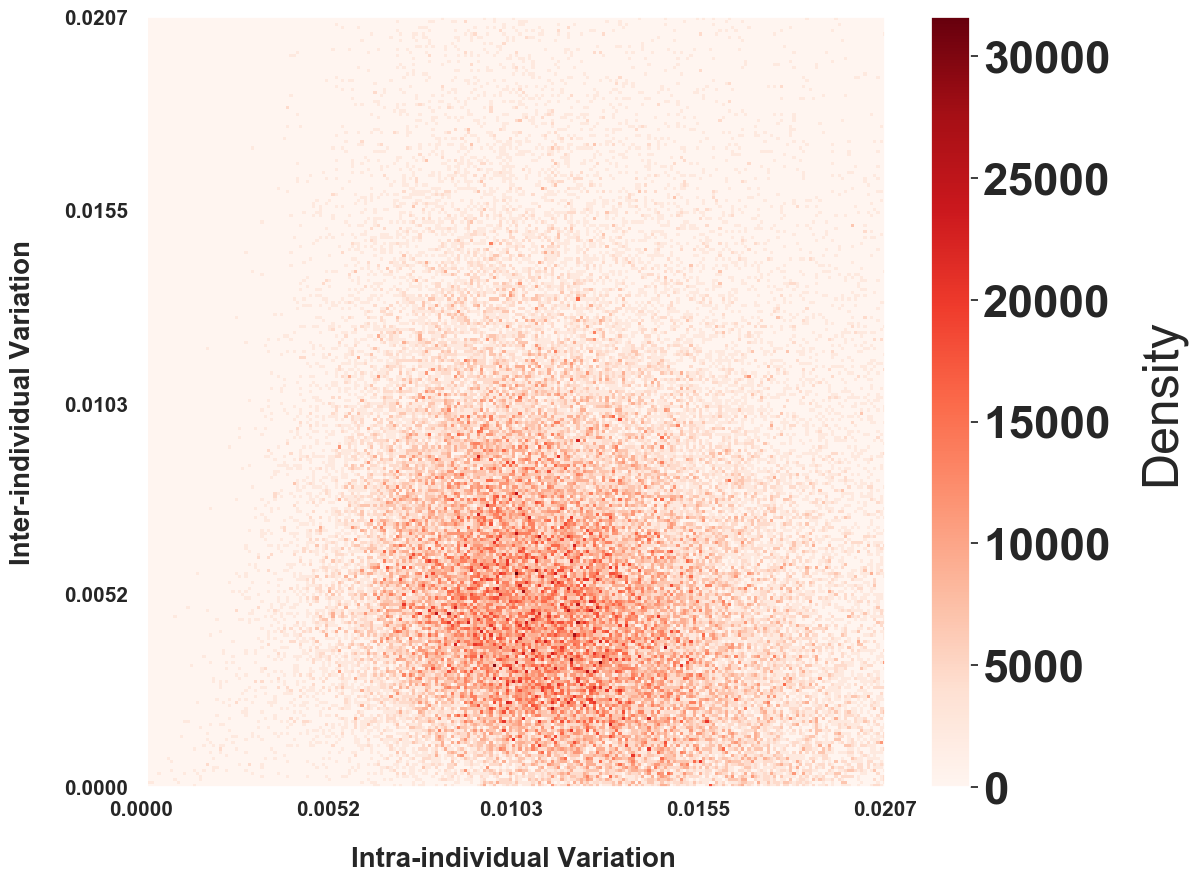

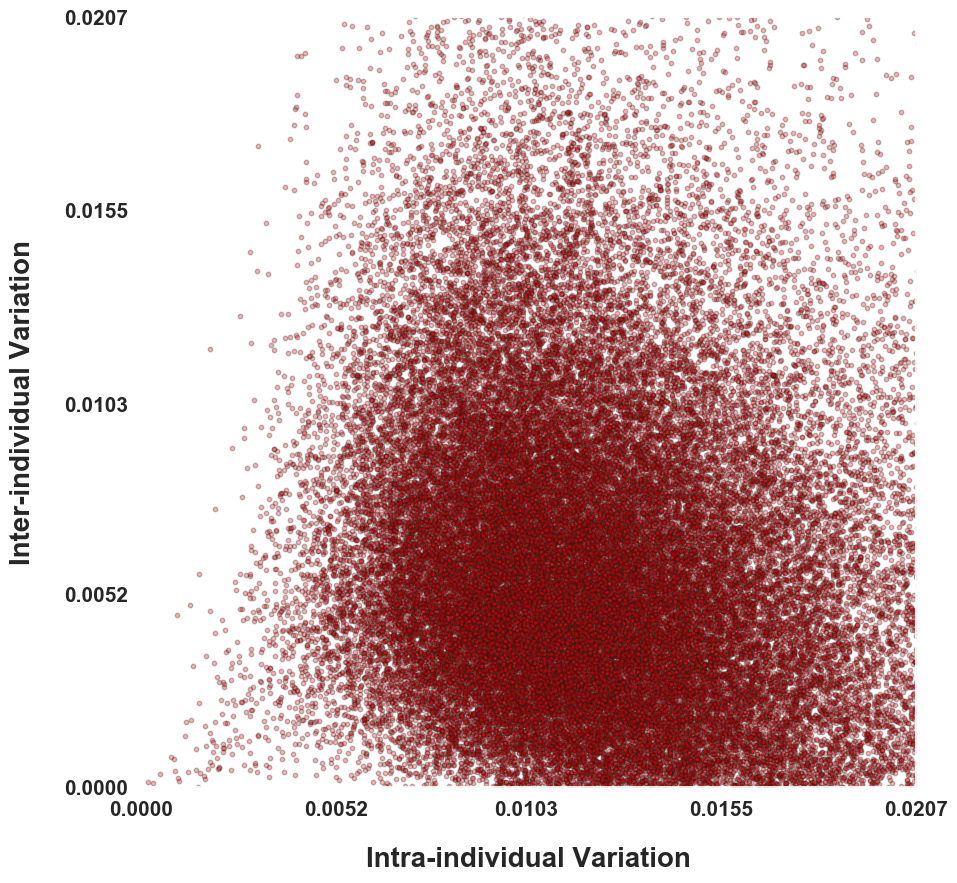

ValueError: not enough values to unpack (expected 4, got 3)

In [9]:
from reliability.reliability_field_maps import plot_field_map

# Set colormaps/colors for field map contours
tasks = ['REST_nogsr',
         'REST_gsr']
taskcolors = {'REST_gsr':'grey',
              'REST_nogsr':'red'}
taskcmaps = {'REST_gsr':'Greys',
             'REST_nogsr':'Reds'}
outpath = False # Not saving any figures for now
lines = True # Show ICC lines
alpha = 1 
thr = 0.0001 # Our threshold for which variability values to include

# Plot individual field maps:
for num,task in enumerate(['REST_nogsr','REST_gsr']):
    x = data[task]['raww'][data[task]['totmask']]
    y = data[task]['rawb'][data[task]['totmask']]
    xx1,yy1,normalized,fig = plot_field_map(x,y,taskcolors[task],taskcmaps[task],alpha,lines,outpath,thr=0.0001,gridsize=100,
                         overlay=False,cbar_option=True,figSize=(12,10),xyLim=95,shade=True,addContourLines=True,plotstyle=['nokde','scatter'],bins=500)



## 2. Field map overlap for GSR and no GSR

In [ ]:
from reliability.reliability_field_maps import plot_field_map_overlay

# Not saving any figures for now.
outpath = False
lines = True
alpha = 1

# Choosing conditions to compare:
taskcombos = [['REST_nogsr',
               'REST_gsr']]

plot_field_map_overlay(taskcombos,data,taskcolors,taskcmaps,alpha,lines,outpath,
                      cbar_option=True,figSize=(13,10),xlim=(0,0.025),ylim=(0,0.025),
                     shade=False,thr=0.0001)

## Generating gradient flow vector angular histograms:
 * Gradient flow vectors are useful understand optimality of change in variation with respect to improved reliability. Gradient flow angular histograms show the frequency of edges for each angle.
 * Gradient flow histograms are created using **gradient_flow_histogram()**.
     * 1. intra- and inter-individual variation is used to calculate standardized gradient flow vectors and the count for each angle is plotted.
     * 2. Each angle is counted and the total number is plotted according to the gradient flow circular colormap.

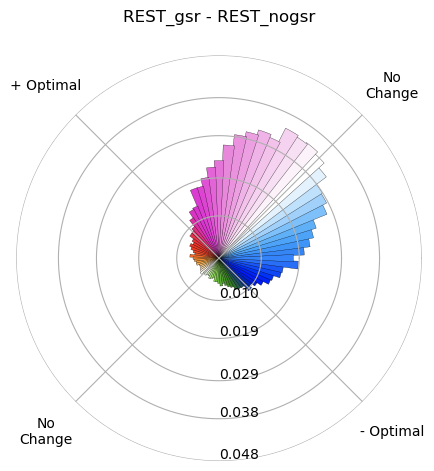

In [6]:
from reliability.gradient_flow_vectors import calc_icc_vectors,pah
from reliability.variability_utils import gradientFlowCmaps

##########################################
# Turn calc_icc_vectors input as pd.df
# Headers with edge names for 360

# Paired masking:
# Input data should be masked such that each intra- and inter-individual variation value are paired between the two conditions
bothmask = data[tasks[0]]['totmask'] * data[tasks[1]]['totmask']

parcdf = {}
measures = ['icc','raww','rawb']
for task in tasks:
    parcdf[task] = {}
    for m in measures:
        parcdf[task][m] = data[task][m][bothmask]

# Calculate vector parameters:
df = calc_icc_vectors(parcdf[tasks[0]]['raww'],parcdf[tasks[0]]['rawb'],parcdf[tasks[0]]['icc'],
                      parcdf[tasks[1]]['raww'],parcdf[tasks[1]]['rawb'],parcdf[tasks[1]]['icc'],
                      tasks[0],tasks[1])

# Gradient flow histogram plot options:
bin_threshold = 5 # degrees covered per histogram bar
outpath = False # No saving for now.
title = '%s - %s' % (tasks[1],tasks[0])

# Plot gradient flow histogram:
pah(df['theta0'],bin_threshold,gradientFlowCmaps['complete'],title,outpath)

